<a href="https://colab.research.google.com/github/midnightoatmeal/prot2func/blob/main/newprot2func.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
df_all = pd.read_csv("protein_sequences.csv")
print(f"Loaded {len(df_all)} protein sequences from CSV.")
df_all.head(10)

Loaded 573230 protein sequences from CSV.


,id,sequence
0,Q6GZX4,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,Q6GZX3,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,Q197F8,MASNTVSAQGGSNRPVRDFSNIQDVAQFLLFDPIWNEQPGSIVPWK...
3,Q197F7,MYQAINPCPQSWYGSPQLEREIVCKMSGAPHYPNYYPVHPNALGGA...
4,Q6GZX2,MARPLLGKTSSVRRRLESLSACSIFFFLRKFCQKMASLVFLNSPVY...
5,Q6GZX1,MNAKYDTDQGVGRMLFLGTIGLAVVVGGLMAYGYYYDGKTPSSGTS...
6,Q197F5,MRYTVLIALQGALLLLLLIDDGQGQSPYPYPGMPCNSSRQCGLGTC...
7,Q6GZX0,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
8,Q91G88,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
9,Q6GZW9,MYKMYFLKDQKFSLSGTIRINDKTQSEYGSVWCPGLSITGLHHDAI...


In [3]:
import requests
import time
from tqdm.notebook import tqdm

def is_enzyme(uniprot_id: str) -> int | None:
    """
    Queries the UniProt API to check if a protein is an enzyme.
    Returns 1 if it is, 0 if not, and None if an error occurs.
    """
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.json"
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None  # Error or not found

        data = response.json()

        # Check for comments of type 'CATALYTICA ACTIVITY' with a valid EC number
        for comment in data.get('comments', []):
            if comment.get('commentType') == 'CATALYTIC ACTIVITY':
                if 'reaction' in comment and comment['reaction'].get('ecNumber'):
                    return 1  # It's an enzyme
        return 0  # Not an enzyme

    except requests.exceptions.RequestException as e:
        print(f"API request failed for {uniprot_id}: {e}")
        return None

# Let's label the first 2000 samples for a better dataset
N_SAMPLES = 2000
df_sample = df_all.head(N_SAMPLES).copy()

# Loop through the sample DataFrame and apply the labeling function
tqdm.pandas(desc="Labeling Proteins")
df_sample['is_enzyme'] = df_sample['id'].progress_apply(lambda pid: is_enzyme(pid))

# Drop any rows where the API call failed
df_labeled = df_sample.dropna(subset=['is_enzyme']).copy()
df_labeled['is_enzyme'] = df_labeled['is_enzyme'].astype(int)

# Save the labeled data for future use
df_labeled.to_csv("labeled_protein_data_2000.csv", index=False)

print(f"\nFinished labeling. Total labeled samples: {len(df_labeled)}")
print("Class distribution:")
print(df_labeled['is_enzyme'].value_counts())

Labeling Proteins:   0%|          | 0/2000 [00:00<?, ?it/s]


Finished labeling. Total labeled samples: 2000
Class distribution:
is_enzyme
0    1649
1     351
Name: count, dtype: int64


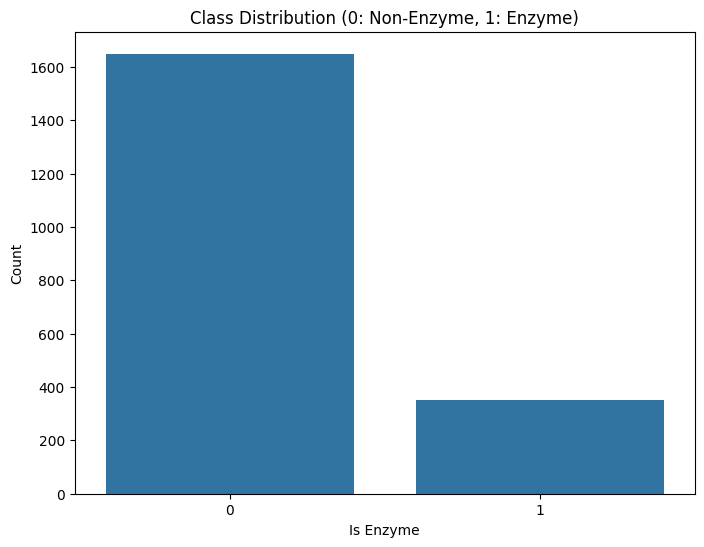

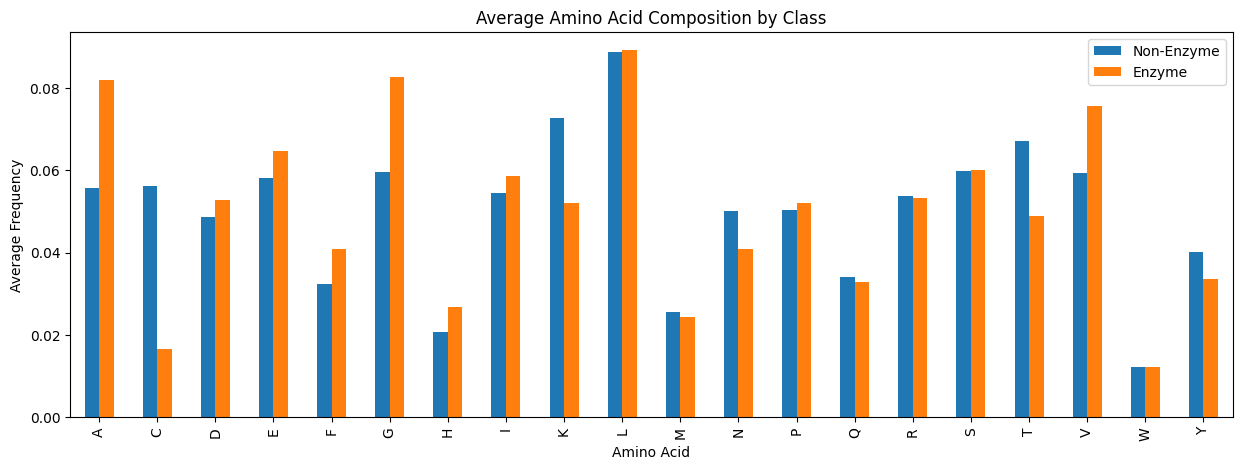

In [4]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Define the 20 standard amino acids
AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

def aa_composition(sequence: str) -> list[float]:
    """Calculates the frequency of each standard amino acid in a sequence."""
    count = Counter(sequence)
    total = len(sequence)
    # Handle cases where a sequence might be empty or invalid
    if total == 0:
        return [0.0] * len(AMINO_ACIDS)
    return [count.get(aa, 0) / total for aa in AMINO_ACIDS]

# Apply the feature engineering function to our labeled data
df_features = df_labeled.copy()
aa_features = df_features["sequence"].apply(lambda seq: pd.Series(aa_composition(seq), index=AMINO_ACIDS))
df_features = pd.concat([df_features, aa_features], axis=1)

# --- Exploratory Data Analysis ---
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x="is_enzyme", data=df_features)
plt.title("Class Distribution (0: Non-Enzyme, 1: Enzyme)")
plt.xlabel("Is Enzyme")
plt.ylabel("Count")
plt.show()

# Visualize the average composition for each class
avg_comp = df_features.groupby("is_enzyme")[AMINO_ACIDS].mean().T
avg_comp.plot(kind="bar", figsize=(15, 5), title="Average Amino Acid Composition by Class")
plt.xlabel("Amino Acid")
plt.ylabel("Average Frequency")
plt.legend(["Non-Enzyme", "Enzyme"])
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df_features[AMINO_ACIDS]
y = df_features["is_enzyme"]

# Create a stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (1600, 20)
Testing set shape: (400, 20)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

print("--- Improved Logistic Regression ---")
# Use class_weight='balanced' to handle the imbalanced data
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train, y_train)

# Evaluate the model
y_pred_lr = lr_model.predict(X_test)
print(classification_report(y_test, y_pred_lr))

--- Improved Logistic Regression ---
              precision    recall  f1-score   support

           0       0.95      0.74      0.83       330
           1       0.39      0.80      0.53        70

    accuracy                           0.75       400
   macro avg       0.67      0.77      0.68       400
weighted avg       0.85      0.75      0.78       400



In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics

print("\n--- Improved PyTorch Neural Network ---")

# Convert data to PyTorch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the Neural Network
class EnzymeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(p=0.5)
        self.out = nn.Linear(32, 2) # Output 2 classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.out(x)

# Calculate class weights for the loss function
class_counts = y_train.value_counts().sort_index()
weights = 1. / torch.tensor(class_counts.values, dtype=torch.float32)
weights = weights / weights.sum()

# Instantiate model, loss, and optimizer
nn_model = EnzymeClassifier()
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    nn_model.train()
    for xb, yb in train_loader:
        pred = nn_model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# Evaluation
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
precision = torchmetrics.Precision(task="multiclass", num_classes=2)
recall = torchmetrics.Recall(task="multiclass", num_classes=2)

nn_model.eval()
all_preds = []
all_labels = []

with torch.inference_mode():
    for xb, yb in test_loader:
        logits = nn_model(xb)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds)
        all_labels.append(yb)

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print("\nPyTorch Model Test Metrics:")
print(f"Accuracy:  {accuracy(all_preds, all_labels):.4f}")
print(f"Precision: {precision(all_preds, all_labels):.4f} (for class 1)")
print(f"Recall:    {recall(all_preds, all_labels):.4f} (for class 1)")


--- Improved PyTorch Neural Network ---
Epoch 10/50, Loss: 0.6580
Epoch 20/50, Loss: 0.4270
Epoch 30/50, Loss: 0.2689
Epoch 40/50, Loss: 0.4186
Epoch 50/50, Loss: 0.2170

PyTorch Model Test Metrics:
Accuracy:  0.8725
Precision: 0.8725 (for class 1)
Recall:    0.8725 (for class 1)
